# Midfielder Exploration
- By Eriberto Contreras

In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
import bamboolib as bam

import unicodedata
import re
import json

import acquire

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression 

#statistical tests
from scipy import stats
from scipy.stats import pearsonr, spearmanr

from math import sqrt
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures


import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filter="ignore"

from bs4 import BeautifulSoup
import prepare
import plotly.express as px

#imports to show interactive visuals on github
import plotly.io as pio
pio.renderers

#forces dataframe to show every columns
pd.set_option('display.max_columns', None)

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# `Acquire` Data.

In [2]:
df = acquire.get_fifa_data()

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Import [Prepare.py](https://github.com/Jules-Ray-Kayla-Bert-Capstone-FiFA/fifa/blob/main/prepare.py) File.
`Summary:`
    This file was created with the purpose of cleaning, encoding, scaling, dropping, and adding collumns to our existing data. It is necessary to complete this preperation step before we start exploring and modeling our data.

In [3]:
#defining df as our imported prepped data.
df = prepare.prepped_data(df)
df

Before dropping nulls, 142079 rows, 111 cols
After dropping nulls. 131489 rows. 66 cols
After cleaning the data and adding additional columns there are: 98804 rows. 83 cols


       sofifa_id      short_name player_positions  overall  potential  \
0         158023        L. Messi       RW, ST, CF       93         93   
1         190871       Neymar Jr          LW, CAM       91         91   
2         231747       K. Mbappé           ST, LW       91         95   
3         230621   G. Donnarumma               GK       89         93   
4         155862    Sergio Ramos               CB       88         88   
...          ...             ...              ...      ...        ...   
98799     234292    L. Järvenpää               RB       57         70   
98800     234294      L. Lingman               RW       57         72   
98801     234297    S. Dahlström               CM       57         72   
98802     234300  L. Lappalainen               ST       57         76   
98803     234296      S. Ylätupa               RW       54         74   

         value_eur  wage_eur  age  height_cm  weight_kg  club_team_id  \
0       78000000.0  320000.0   34        170      

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Seperating Goalkeepers, Forwards, & Midfielders

In [4]:
goalkeeper_df, forward_df, midfielder_df, defender_df = prepare.acquire_players_by_position(df)

# Focusing on midfielders on this section

In [5]:
df = midfielder_df

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Splitting Data

In [6]:
train, validate, test = prepare.split(df)

Train: 21872 rows, 83 cols
Validate: 9695 rows, 83 cols
Test: 5115 rows, 83 cols


<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# `Explore`

## Importing split function to start our exploring on our train data.

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Relationship to Wage_euro Plot

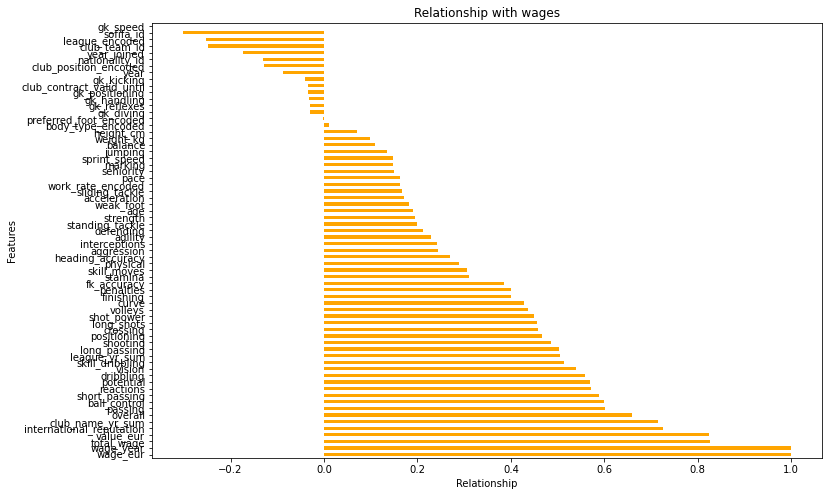

In [8]:
plt.figure(figsize = (12,8))
train.corr()['wage_eur'].sort_values(ascending=False).plot(kind='barh', color='orange')
plt.title('Relationship with wages')
plt.xlabel('Relationship')
plt.ylabel('Features')
plt.show()

In [111]:
features_cor =  train.corr()['wage_eur'].sort_values(ascending=False)
features_cor = pd.DataFrame(features_cor)
features_cor.tail(62)

                          wage_eur
international_reputation  0.724793
club_name_yr_sum          0.714032
overall                   0.659235
passing                   0.601636
ball_control              0.599633
...                            ...
year_joined              -0.173610
club_team_id             -0.248620
league_encoded           -0.252098
sofifa_id                -0.302797
gk_speed                       NaN

[62 rows x 1 columns]

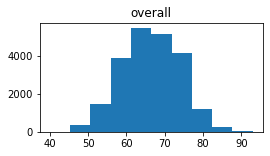

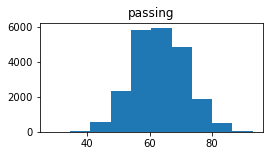

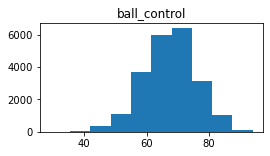

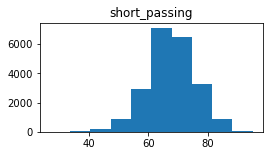

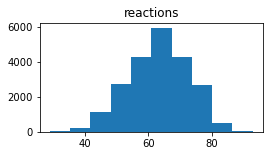

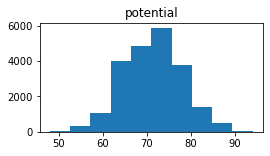

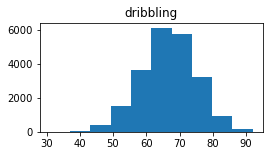

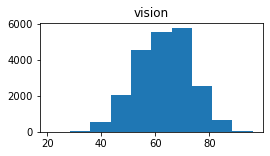

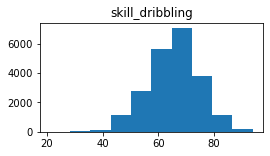

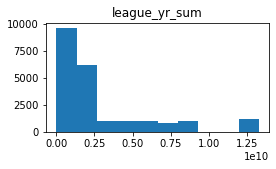

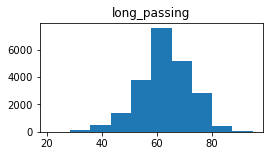

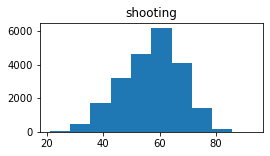

In [10]:
cols = ['overall', 'passing', 'ball_control', 'short_passing', 'reactions', 'potential', 'dribbling', 'vision', 'skill_dribbling', 'league_yr_sum', 'long_passing', 'shooting']
# graphing each colum seperately
for col in cols:
    #graph size
    plt.figure(figsize=(4,2))
    #histogram graph
    plt.hist(train[col])
    #title of column
    plt.title(col)
    # show graph
    plt.show()

`Takeaways:` 
For this Exploration section I wil be focusing on the skills that are under or equal to 70 percent of correlation and greater then 48 percent. 
The list below will be the skills and stats that I will be focusing on.

- overall
- passing
- ball_control
- short_passing
- reactions
- potential
- dribbling
- vision
- skill_dribbling
- league_yr_sum
- long_passing
- shooting



<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Questions to answer during exploration process?

`Does age impact salary?`

`Does seniority(length of time playing with a club) impact salary?`

`Does the club you start with impact your salary?`

`Do players with unusual body types have higher or lower salaries?`

`Does nationality impact salary?`

`Does international reputation impact salary?`

`Does Overall performance impact salary?`


<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# `Start`
***

In [26]:
# identifying our alpha value for correlation testing.
alpha = .05

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>


#  `Age` &`Wage`?
***

<AxesSubplot:xlabel='age', ylabel='wage_eur'>

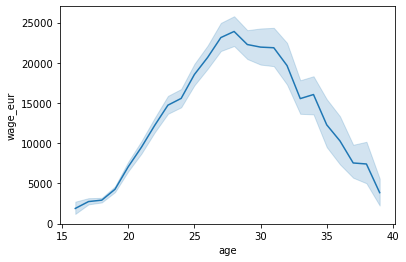

In [12]:
sns.lineplot(data=train, x = 'age' ,y= 'wage_eur')

###  Age & Wage (corr) test:
Null $h_0$ Hypothesis = There is no linear correlation between the age of a player and wage_eur.

Alternative $h_a$ Hypothesis  = there is a linear correlation between the age of a player and wage_eur.

In [14]:
# corralation with age and wage_eur
corr, p = stats.pearsonr(train.age, train.wage_eur)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.19127255804842686 , p value: 2.8084312871324435e-179
Pvalue is: 2.8084312871324435e-179 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


`Takeaways:`
   - Age seems to have a small correlation of %19

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# `Seniority`  & `Wage`?
***

<AxesSubplot:xlabel='seniority', ylabel='wage_eur'>

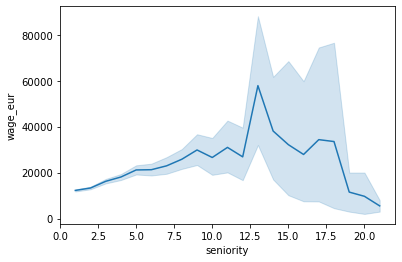

In [15]:
sns.lineplot(data=train, x = 'seniority' ,y= 'wage_eur')

***
###  Seniority & Wage (corr) test:
Null $h_0$ Hypothesis = There is no linear correlation between seniority of a player and wage_eur.

Alternative $h_a$ Hypothesis  = there is a linear correlation between seniority of a player and wage_eur.

In [17]:
## corralation with seniority and wage_eur count
corr, p = stats.pearsonr(train.seniority, train.wage_eur)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.14973767570804689 , p value: 7.32221065914197e-110
Pvalue is: 7.32221065914197e-110 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


`Takeaways:`
   - Seniority seems to have a small correlation of %15

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# `Club` & `Salary`?
***

In [19]:
clubs = train.groupby('club_name')['wage_eur'].sum().reset_index()
clubs = clubs.sort_values('wage_eur', ascending=False)

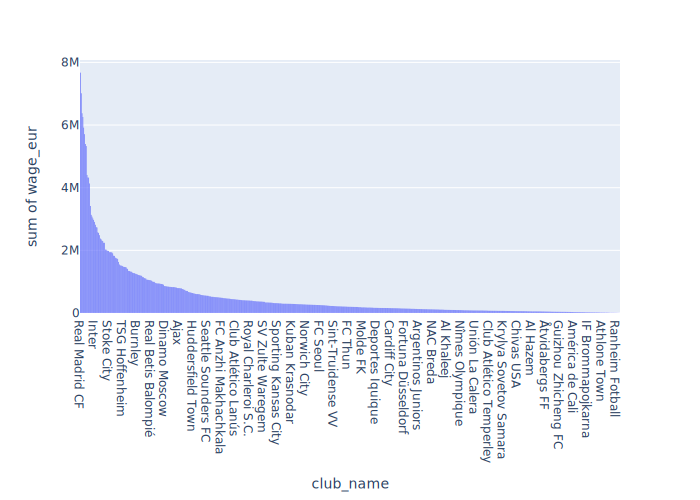

In [20]:
import plotly.express as px
fig = px.histogram(clubs, x='club_name', y='wage_eur')
fig.show(renderer="svg")

***
###  Club & Wage (corr) test:
Null $h_0$ Hypothesis = There is no linear correlation between Club of a player and wage_eur.

Alternative $h_a$ Hypothesis  = there is a linear correlation between Club of a player and wage_eur.

In [23]:
alpha = 0.05
#get sample
bar_sample = train[train.club_name == 'FC Barcelona'].wage_eur

#get mean
overall_mean = train.wage_eur.mean()

## corralation with club_name and wage_eur count
#perform test
t, p = stats.ttest_1samp(bar_sample, overall_mean)

#print p-value
print(f'P Value: {p/2:.3f}')

#evaluate if mean of Barcelona wages is significantly higher than all wages, is p/2 < a and t > 0?
if p/2 < alpha and t > 0:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

P Value: 0.000
Reject the null hypothesis.


`Takeaways:`
   - Club seems to have a no correlation

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# `Body types` & `Wage`?
***

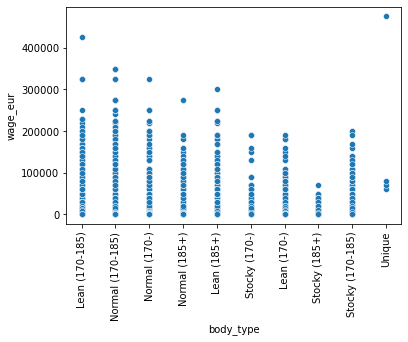

In [91]:
ax = sns.scatterplot(data=train, x = 'body_type' ,y= 'wage_eur')
ax.tick_params(axis='x', rotation=90)

In [41]:
## corralation with body type and wage_eur count
corr, p = stats.pearsonr(train.body_type_encoded, train.wage_eur)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.011160837845971052 , p value: 0.09882966809337548
Pvalue is: 0.09882966809337548 is greater than alpha: 0.05
We fail to reject the null hypothesis because there is no significant correlation present


`Takeaways:`
   - Body_type seems to have a no correlation

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# National team & Wage?
***

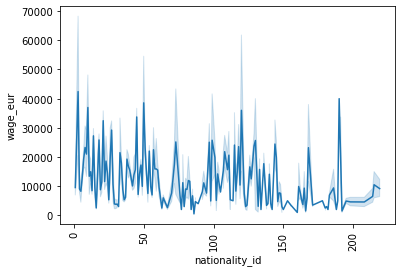

In [43]:
ax = sns.lineplot(data=train, x = 'nationality_id' ,y= 'wage_eur')
ax.tick_params(axis='x', rotation=90)

In [45]:
## corralation with body type and wage_eur count
corr, p = stats.pearsonr(train.nationality_id, train.wage_eur)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: -0.13055612897857544 , p value: 9.350968504526944e-84
Pvalue is: 9.350968504526944e-84 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


`Takeaways:`
   - Nationality_id seems to have a small negative correlation of %13

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# International reputation & Wage?
***

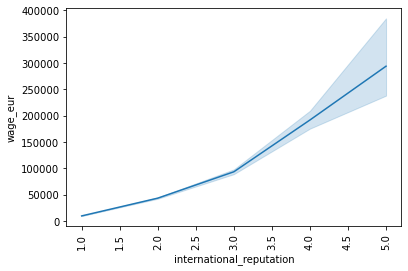

In [48]:
ax = sns.lineplot(data=train, x = 'international_reputation' ,y= 'wage_eur')
ax.tick_params(axis='x', rotation=90)

In [107]:
## corralation with international_reputation and wage_eur count
corr, p = stats.pearsonr(train.international_reputation, train.wage_eur)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.7247929568158278 , p value: 0.0
Pvalue is: 0.0 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


`Takeaways:`
   - International_reputation has" a huge correlation of %72

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Overall & Wage?
***

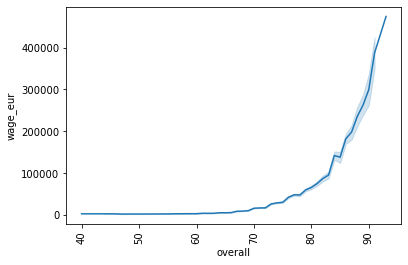

In [52]:
ax = sns.lineplot(data=train, x = 'overall' ,y= 'wage_eur')
ax.tick_params(axis='x', rotation=90)

In [51]:
## corralation with international_reputation and wage_eur count
corr, p = stats.pearsonr(train.overall, train.wage_eur)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.6592347524118041 , p value: 0.0
Pvalue is: 0.0 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


`Takeaways:`
   - Overall performance has a huge correlation of %65

 <hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Ball_control & Wage
***

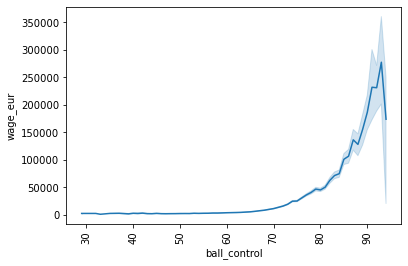

In [68]:
ax = sns.lineplot(data=train, x = 'ball_control' ,y= 'wage_eur')
ax.tick_params(axis='x', rotation=90)

In [54]:
## corralation with ball_control and wage_eur count
corr, p = stats.pearsonr(train.ball_control, train.wage_eur)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.5996334458188043 , p value: 0.0
Pvalue is: 0.0 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


`Takeaways:`
   - Ball_control has a huge correlation of %59

 <hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Short_passing & wage
***

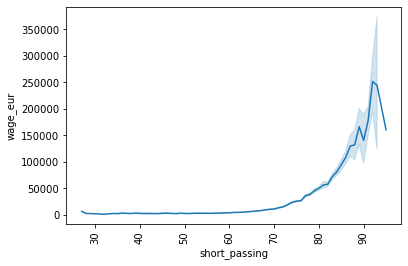

In [69]:
ax = sns.lineplot(data=train, x = 'short_passing' ,y= 'wage_eur')
ax.tick_params(axis='x', rotation=90)

In [55]:
## corralation with short_passing and wage_eur count
corr, p = stats.pearsonr(train.short_passing, train.wage_eur)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.5887318301909871 , p value: 0.0
Pvalue is: 0.0 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


`Takeaways:`
   - Short_passing has a huge correlation of %59

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Passing & wage
***

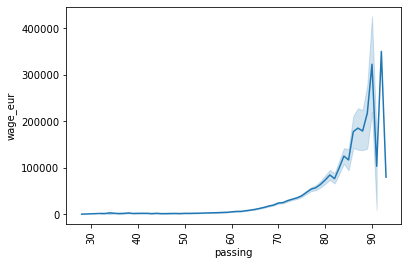

In [70]:
ax = sns.lineplot(data=train, x = 'passing' ,y= 'wage_eur')
ax.tick_params(axis='x', rotation=90)

In [56]:
## corralation with passing and wage_eur count
corr, p = stats.pearsonr(train.passing, train.wage_eur)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.6016364128395981 , p value: 0.0
Pvalue is: 0.0 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


`Takeaways:`
   - Passing has a huge correlation of %60

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Reactions & wage
***

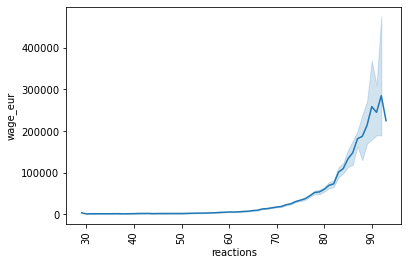

In [71]:
ax = sns.lineplot(data=train, x = 'reactions' ,y= 'wage_eur')
ax.tick_params(axis='x', rotation=90)

In [57]:
## corralation with reactions and wage_eur count
corr, p = stats.pearsonr(train.reactions, train.wage_eur)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.5716205708266117 , p value: 0.0
Pvalue is: 0.0 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


`Takeaways:`
   - Reactions has a huge correlation of %57

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Potential & wage
***

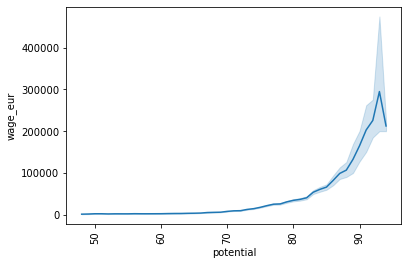

In [72]:
ax = sns.lineplot(data=train, x = 'potential' ,y= 'wage_eur')
ax.tick_params(axis='x', rotation=90)

In [58]:
## corralation with potential and wage_eur count
corr, p = stats.pearsonr(train.potential, train.wage_eur)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.5684853349750085 , p value: 0.0
Pvalue is: 0.0 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


`Takeaways:`
   - Potential has correlation of %57

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Dribbling & wage
***

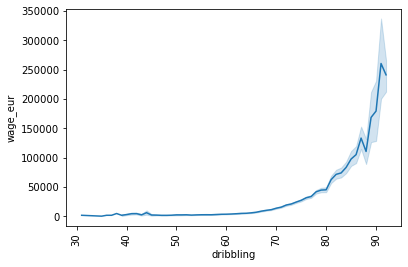

In [73]:
ax = sns.lineplot(data=train, x = 'dribbling' ,y= 'wage_eur')
ax.tick_params(axis='x', rotation=90)

In [59]:
## corralation with dribbling and wage_eur count
corr, p = stats.pearsonr(train.dribbling, train.wage_eur)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.558698346739521 , p value: 0.0
Pvalue is: 0.0 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


`Takeaways:`
   - Dribbling has a huge correlation of %56

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Vision & wage
***

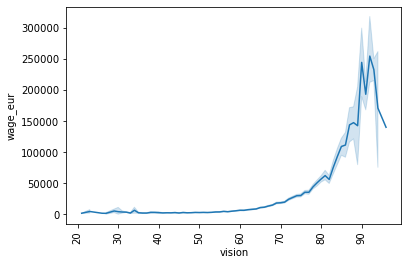

In [74]:
ax = sns.lineplot(data=train, x = 'vision' ,y= 'wage_eur')
ax.tick_params(axis='x', rotation=90)

In [60]:
## corralation with vision and wage_eur count
corr, p = stats.pearsonr(train.vision, train.wage_eur)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.5389802245160967 , p value: 0.0
Pvalue is: 0.0 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


`Takeaways:`
   - Vision has a huge correlation of %54

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Skill_dribbling & wage
***

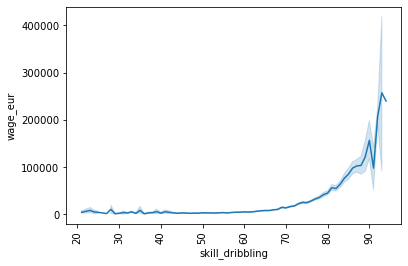

In [75]:
ax = sns.lineplot(data=train, x = 'skill_dribbling' ,y= 'wage_eur')
ax.tick_params(axis='x', rotation=90)

In [61]:
## corralation with skill_dribbling and wage_eur count
corr, p = stats.pearsonr(train.skill_dribbling, train.wage_eur)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.5144167682241341 , p value: 0.0
Pvalue is: 0.0 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


`Takeaways:`
   - Skill_dribbling has a huge correlation of %51

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# League_yr_sum & wage
***

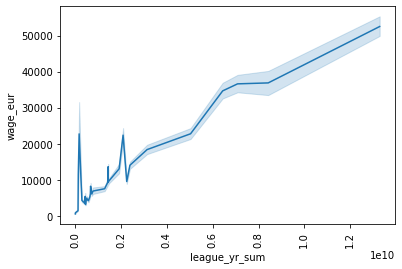

In [76]:
ax = sns.lineplot(data=train, x = 'league_yr_sum' ,y= 'wage_eur')
ax.tick_params(axis='x', rotation=90)

In [62]:
## corralation with league_yr_sum and wage_eur count
corr, p = stats.pearsonr(train.league_yr_sum, train.wage_eur)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.5048714288028968 , p value: 0.0
Pvalue is: 0.0 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


`Takeaways:`
   - League_year_sum has a decent correlation of %50

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Long_passing & wage
***

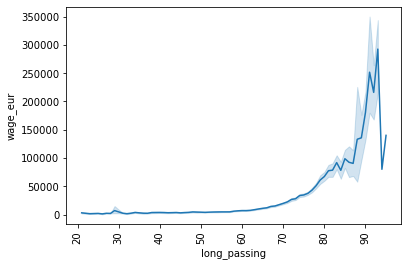

In [77]:
ax = sns.lineplot(data=train, x = 'long_passing' ,y= 'wage_eur')
ax.tick_params(axis='x', rotation=90)

In [63]:
## corralation with long_passing and wage_eur count
corr, p = stats.pearsonr(train.long_passing, train.wage_eur)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.5032374381788052 , p value: 0.0
Pvalue is: 0.0 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


`Takeaways:`
   - Long_passing has a decent correlation of %50

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# Shooting & wage
***

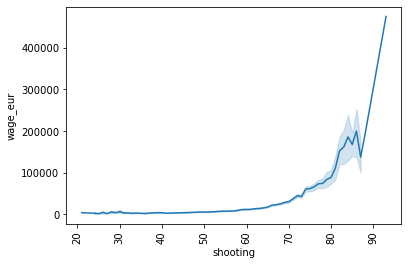

In [78]:
ax = sns.lineplot(data=train, x = 'shooting' ,y= 'wage_eur')
ax.tick_params(axis='x', rotation=90)

In [79]:
## corralation with shooting and wage_eur count
corr, p = stats.pearsonr(train.shooting, train.wage_eur)
corr, p
#correlation test summary
print("correlation:", corr,",","p value:",p)
if p < alpha:
    print(f'Pvalue is: {p} is less than alpha: {alpha}')
    print("Reject the null hypothesis because there is a correlation present")
else:
    print(f'Pvalue is: {p} is greater than alpha: {alpha}')
    print("We fail to reject the null hypothesis because there is no significant correlation present")

correlation: 0.4858371199206199 , p value: 0.0
Pvalue is: 0.0 is less than alpha: 0.05
Reject the null hypothesis because there is a correlation present


`Takeaways:`
   - Shoting has decent correlation of %49

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# `Exploration Summary:`

- Age seems to have a small correlation of %19
- Seniority seems to have a small correlation of %15
- Club seems to have a no correlation
- Body_type seems to have a no correlation
- Nationality_id seems to have a small negative correlation of %13
- International_reputation has a huge correlation of %72
***
- Overall performance has a huge correlation of %65
- Ball_control has a huge correlation of %59
- Short_passing has a huge correlation of %59
- Passing has a huge correlation of %60
- Reactions has a huge correlation of %57
- Potential has correlation of %57
- Dribbling has a huge correlation of %56
- Vision has a huge correlation of %54
- Skill_dribbling has a huge correlation of %51
- League_year_sum has a decent correlation of %50
- Long_passing has a decent correlation of %50
- Shoting has decent correlation of %49
***
## Next we will build an MVP and focus on modeling.

# [End of Midfielder Exploration]